In [2]:
import os
from pathlib import Path

cwd = Path(os.getcwd())
print(cwd)
root = cwd.parent
os.chdir(root)
print(root)

c:\Users\hector.papoulias\Desktop\Docs\Repos\transaction_anomaly_detection\demos
c:\Users\hector.papoulias\Desktop\Docs\Repos\transaction_anomaly_detection


In [3]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="dark:#5A9_r")

# Synthetic Data Generation

In [137]:
import pandas as pd
import numpy as np

n_normal_datapoints = 10000
n_anomalous_datapoints = 100

np.random.seed(0)

# Generate in-distribution data
data_normal = {
    'continuous_feature': np.random.normal(loc=0, scale=0.1, size=n_normal_datapoints)
}
df_normal = pd.DataFrame(data_normal)
df_normal['anomaly'] = False

# Generate out-of-distribution data
data_anomalies = {
    'continuous_feature': np.random.normal(loc=0, scale=0.1, size=n_anomalous_datapoints)
}
df_anomalies = pd.DataFrame(data_anomalies)
df_anomalies['continuous_feature'] = df_anomalies['continuous_feature'].apply(lambda x: round(x, 2))
df_anomalies['anomaly'] = True

# Join normal and anomalous datapoints to form synthetic dataset
df=pd.concat([df_normal, df_anomalies]).reset_index(drop=True)
df

,continuous_feature,anomaly
0,0.176405,False
1,0.040016,False
2,0.097874,False
3,0.224089,False
4,0.186756,False
...,...,...
10095,-0.100000,True
10096,-0.250000,True
10097,0.080000,True
10098,-0.010000,True


# BERT Encoder Training

In [82]:
corpus = df['continuous_feature'].apply(lambda x: str(x)).tolist()

character_tokens = list(
    set(
        "".join(corpus)
        )
    )

max_str_len = max([len(str_example) for str_example in corpus])

In [92]:
import torch.nn as nn
from transaction_anomaly_detection.models.text_encoder import TextEncoder

text_encoder = TextEncoder(
    ls_tokens=character_tokens,
    max_n_standard_tokens=max_str_len,
    d_model=8,
    n_encoder_layers=2,
    n_parallel_heads_per_layer=2,
    dim_feedforward=4*8,
    activation=nn.GELU(),
    layer_norm_eps=1e-5,
    dropout_rate=0.3,
)

In [93]:
print(f'n_params: {text_encoder.get_n_params()}')

n_params: 2016


In [94]:
import numpy as np

dict_loss_evolution_bert = text_encoder.fit(
    corpus=corpus,
    val_ratio=0.1,
    sz_batch=512,
    learning_rate=0.001,
    patience=20,
    loss_delta_threshold=0.001,
    max_n_epochs=np.nan,
    verbose=False
    )

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Min Val Loss @Epoch 95: 1.6030772924423218 


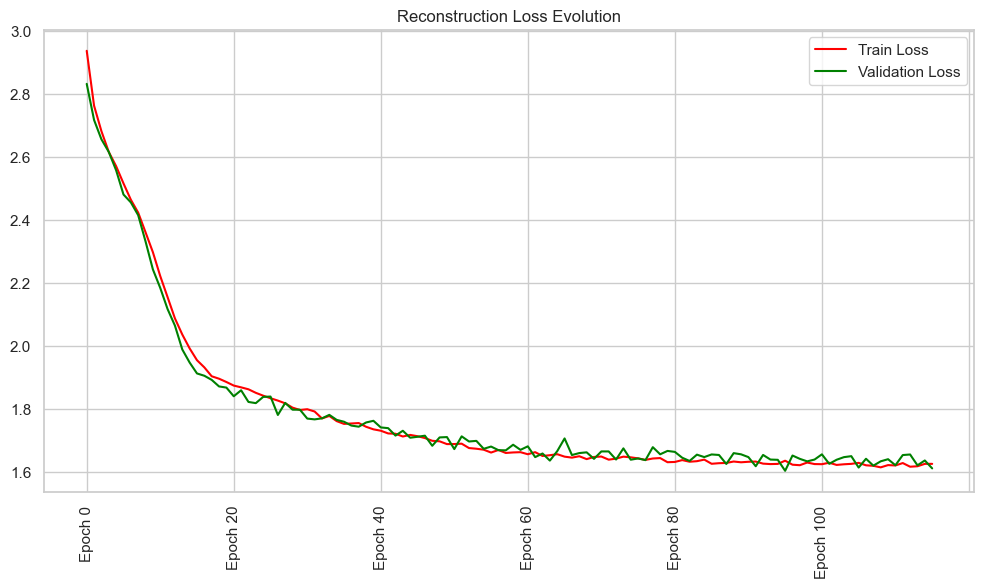

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(12,6)
)

dict_loss_evolution_bert['train'].plot(ax = ax, rot=90, color='red')
dict_loss_evolution_bert['val'].plot(ax = ax, rot=90, color='green')

plt.title('Reconstruction Loss Evolution')
plt.legend(["Train Loss", "Validation Loss"])

In [96]:
text_encoder.encode('1.23245678986').mean()

tensor(1.5412)

In [97]:
text_encoder.encode('1.23').mean()

tensor(2.3062)

In [139]:
ls_bert_encodings = text_encoder.encode(df['continuous_feature'].apply(lambda x: str(x)).tolist())
ls_bert_encodings = list(map(lambda x: x.mean().item(), ls_bert_encodings))
df['continuous_feature_repr'] = ls_bert_encodings
df

,continuous_feature,anomaly,continuous_feature_repr
0,0.176405,False,1.407512
1,0.040016,False,1.335750
2,0.097874,False,1.601030
3,0.224089,False,1.627482
4,0.186756,False,1.409330
...,...,...,...
10095,-0.100000,True,2.287279
10096,-0.250000,True,2.355516
10097,0.080000,True,2.006488
10098,-0.010000,True,2.283629


# Autoencoder

In [110]:
from transaction_anomaly_detection.models import TransactionAnomalyDetector
import torch.nn as nn

anomaly_detector = TransactionAnomalyDetector(
    dict_cat_feature_to_ls_categories_n_embd={},
    ls_con_features= ['continuous_feature', 'continuous_feature_repr'],
    encoder_layer_szs=[1024, 512, 256, 128, 64, 32, 8, 4, 2],
    ae_activation=nn.LeakyReLU(0.01),
    dropout_rate=0.1,
    batchswap_noise_rate=0.1
    )

In [111]:
print(f'n_params: {anomaly_detector.get_n_params()}')

n_params: 1413622


In [112]:
import numpy as np

dict_loss_evolution_ae = anomaly_detector.fit(
    df_dataset=df,
    sz_batch=512,
    learning_rate=0.0001,
    patience=25,
    loss_delta_threshold=0.001,
    max_n_epochs=np.inf,
    val_ratio=0.1,
    contamination=0.01,
    verbose=False
    )

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Min Val Loss @Epoch 302: 0.380766831060095 


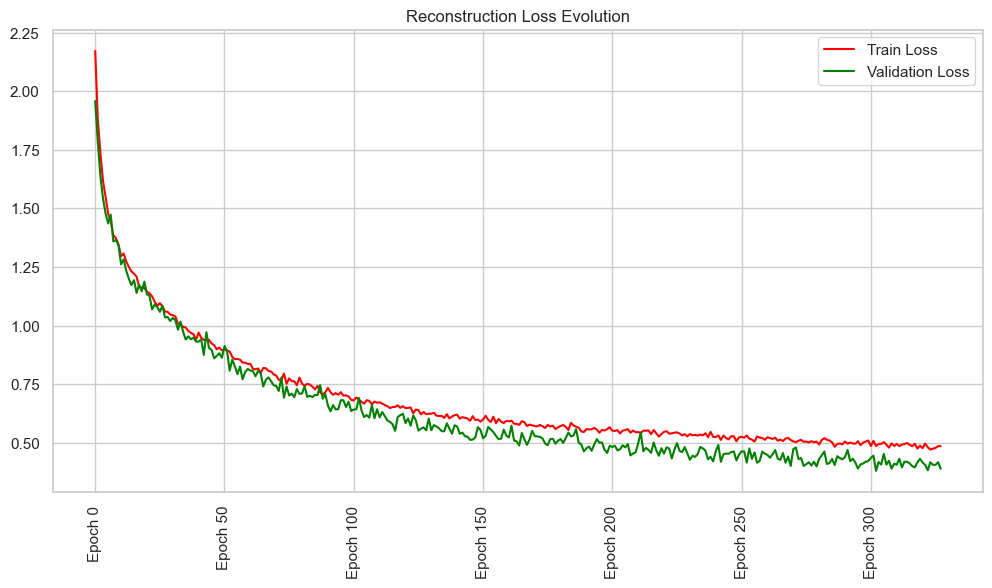

In [113]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(12,6)
)

dict_loss_evolution_ae['train'].plot(ax = ax, rot=90, color='red')
dict_loss_evolution_ae['val'].plot(ax = ax, rot=90, color='green')

plt.title('Reconstruction Loss Evolution')
plt.legend(["Train Loss", "Validation Loss"])

In [141]:
anomaly_detector.fit_reconstruction_loss_threshold(
    df_dataset=df,
    contamination=0.01
    )
print(f'Reconstruction Loss Threshold for Anomaly Detection: {anomaly_detector.reconstruction_loss_threshold}')

Reconstruction Loss Threshold for Anomaly Detection: 2.2039041278129514


In [143]:
df_detected_anomalies = anomaly_detector.detect_anomalies(df)
df_detected_anomalies

,loss,index,continuous_feature,anomaly,continuous_feature_repr
loss_rank,,,,,
0,13.572957,10024,-0.280000,True,2.412452
1,11.785123,10096,-0.250000,True,2.355516
2,10.166485,10060,-0.180000,True,2.387072
3,10.166485,10079,-0.180000,True,2.387072
4,9.623499,10084,-0.190000,True,2.324723
...,...,...,...,...,...
90,2.239063,6727,-0.306921,False,1.076914
91,2.226542,10029,0.210000,True,2.116396
92,2.215964,10088,0.050000,True,1.971351


In [144]:
idx_anom = df_detected_anomalies['original_index'].tolist()
n_tp = len(df_detected_anomalies[df_detected_anomalies['anomaly'] == True])
n_fp = len(df_detected_anomalies[df_detected_anomalies['anomaly'] == False])
n_tn = len(df[(~df.index.isin(idx_anom)) & (df['anomaly']==False)])
n_fn = len(df[(~df.index.isin(idx_anom)) & (df['anomaly']==True)])

precision = n_tp/(n_tp + n_fp)
recall = n_tp/(n_tp + n_fn)
f1=2*precision*recall/(precision+recall)

print('Anomaly Detection Evaluation:')

print('\n')
print(f'n_tp: {n_tp}')
print(f'n_fp: {n_fp}')
print(f'n_tn: {n_tn}')
print(f'n_fn: {n_fn}')

print('\n')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')

Anomaly Detection Evaluation:


n_tp: 86
n_fp: 9
n_tn: 9991
n_fn: 14


precision: 0.9052631578947369
recall: 0.86
f1: 0.8820512820512821
